## Trabajo Práctico 1

### Fecha de entrega: 02/10


1. Entrene una red de Hopfield ‘82 con las imágenes binarias disponibles en el campus.

a) Verifique si la red aprendió las imágenes enseñadas.

b) Evalúe la evolución de la red al presentarle versiones alteradas de las imágenes
aprendidas: agregado de ruido, elementos borrados o agregados.

c) Evalúe la existencia de estados espurios en la red: patrones inversos y
combinaciones de un número impar de patrones. (Ver Spurious States, en la sección
2.2, Hertz, Krogh & Palmer, pág. 24).

d) Realice un entrenamiento con las 6 imágenes disponibles. ¿Es capaz la red de
aprender todas las imágenes? Explique.

## Desarrollo


Se escribe la función que permite convertir bitmaps en imagenes de un tamaño definido, la función que convierte las imágenes en un arreglo de 1s y -1s, y una función que toma un arreglo de -1s y 1s y los representa como una imagen

In [1]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
def pad_image(file_path, target_size=(60, 50)):
    image = Image.open(file_path)
    width, height = image.size
    pad_width = (target_size[0] - width) // 2
    pad_height = (target_size[1] - height) // 2
    padded_image = ImageOps.expand(image, border=(pad_width, pad_height), fill=0)
    padded_image = padded_image.crop((0, 0, target_size[0], target_size[1]))
    return padded_image

def bmp_to_list(image):
    array = np.array(image)
    array = np.where(array == 0, -1, array)
    array = array.ravel()
    array = array.tolist()
    for i in range(len(array)):
        if array[i] == -1:
            array[i] = 1
        else:
            array[i] = -1

    return array

def create_composite_image(image, target_size = (60, 50)):

    image_array = np.array(image) 
    image_array = 255 - image_array
    reshaped_image = image_array.reshape(target_size[1], target_size[0])

    plt.figure(figsize=(5, 5))
    plt.imshow(reshaped_image, cmap='gray')
    plt.show()



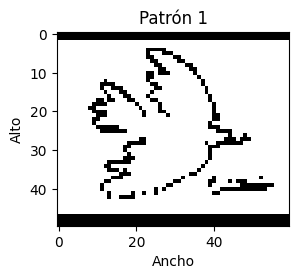

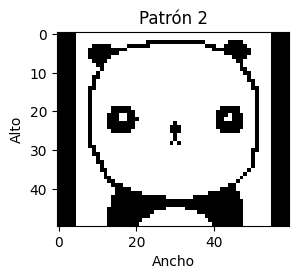

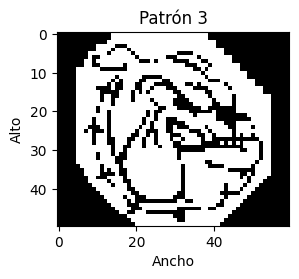

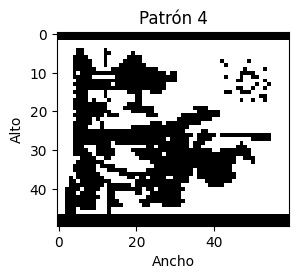

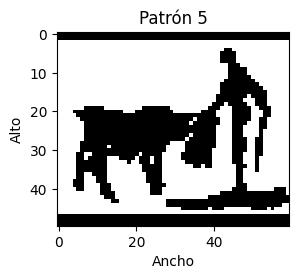

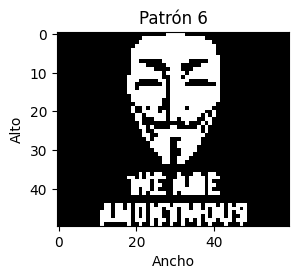

In [66]:
import os

# Define the path to the 'images' folder
folder_path = 'imagenes'

# Create an empty list to store the arrays
image_list = []
padded_image_list = []

# Iterate over the files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file has the '.bmp' extension
    if file_name.endswith('.bmp'):
        # Get the full file path
        file_path = os.path.join(folder_path, file_name)
        image = pad_image(file_path)
        padded_image_list.append(image)
        # Call bmp_to_array and append the result to the list
        image_array = bmp_to_list(image)
        image_list.append(image_array)
for padded_image in padded_image_list:
    plt.figure(figsize=(3,3))
    plt.imshow(np.array(padded_image), cmap='gray')
    # change dimensions of the plot
    ## plt.axis('off')  # Hide the axis
    plt.xlabel("Ancho")
    plt.ylabel("Alto")
    plt.title(f'Patrón {padded_image_list.index(padded_image)+1}')
    plt.show() 

In [3]:
class HopfieldNetwork:
    def __init__(self, num_neurons):
        self.num_neurons = num_neurons
        self.weights = np.zeros((num_neurons, num_neurons))
    def train(self,patterns, eta = 1):
        for pattern in patterns:
            self.weights += eta * np.outer(pattern, pattern)
        np.fill_diagonal(self.weights, 0)    
    def run(self, pattern):
        new_pattern = pattern.copy()
        indexes = np.random.permutation(self.num_neurons)
        for index in indexes:
            weighted_value = np.dot(self.weights[index], new_pattern)
            new_pattern[index] = 1 if weighted_value > 0 else -1
        return new_pattern
    def run_syncronically(self, pattern):
        new_pattern = pattern.copy()
        weighted_value = np.dot(self.weights, new_pattern)
        new_pattern = np.where(weighted_value > 0, 1, -1)
        return new_pattern

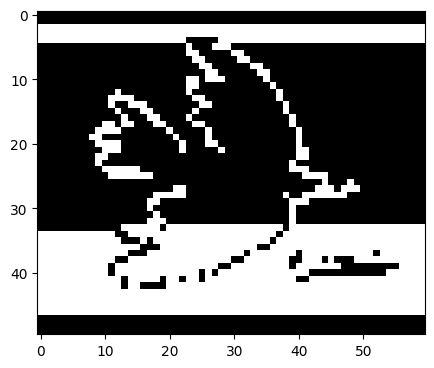

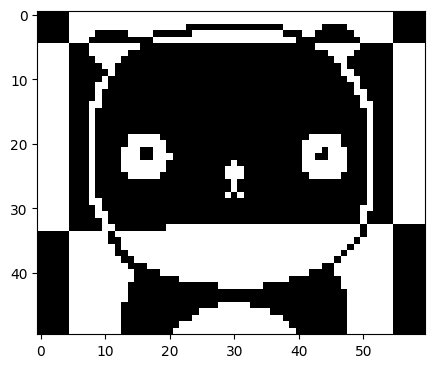

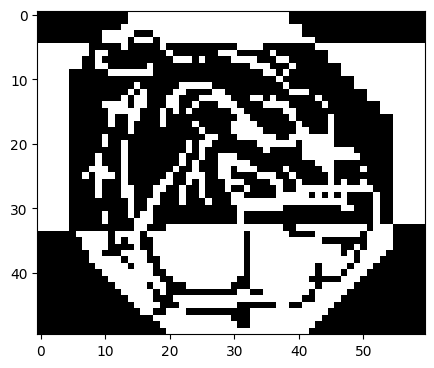

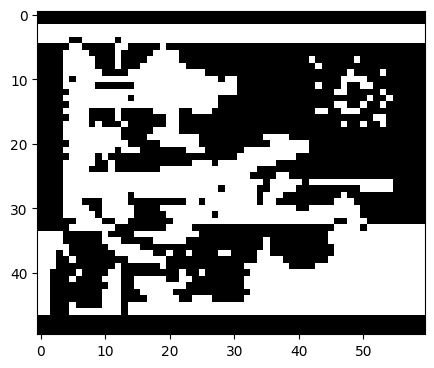

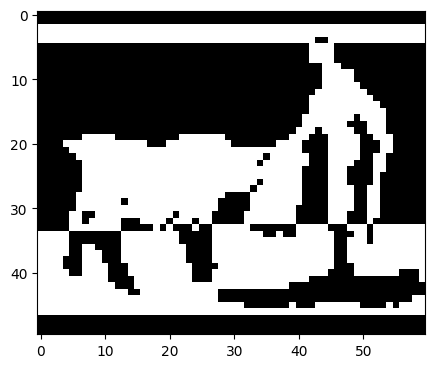

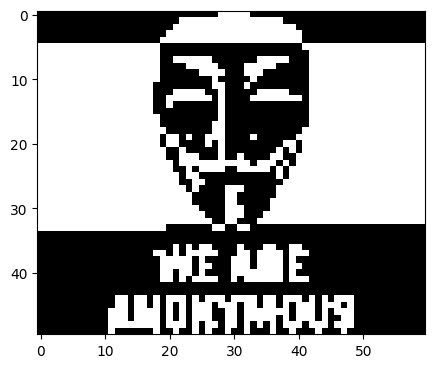

In [4]:
num_neurons = 60 * 50
num_patterns = len(image_list)

hopfield_network = HopfieldNetwork(num_neurons)
hopfield_network.train(image_list, 200)

## Genero un patrón ruidoso
noisy_pattern = image_list.copy()
for pattern in noisy_pattern:
    # agrego una banda negra de 1500 pixeles
    pattern[300:2000] = -np.array(pattern[300:2000])
    create_composite_image(pattern)



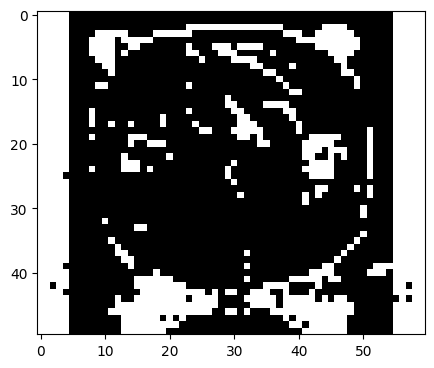

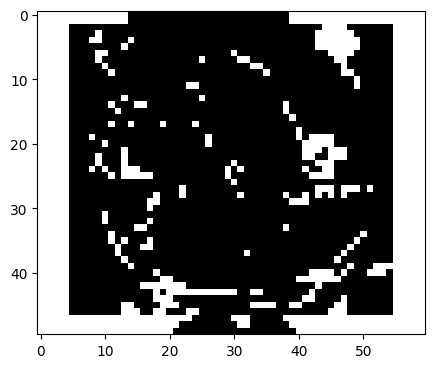

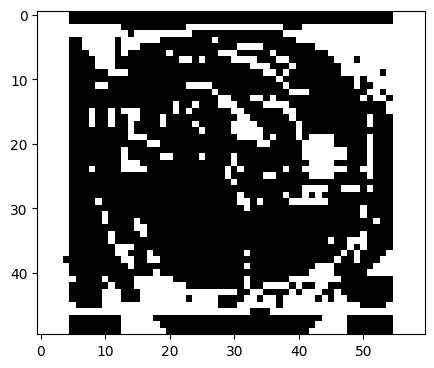

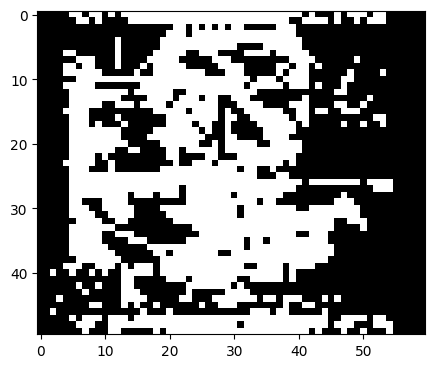

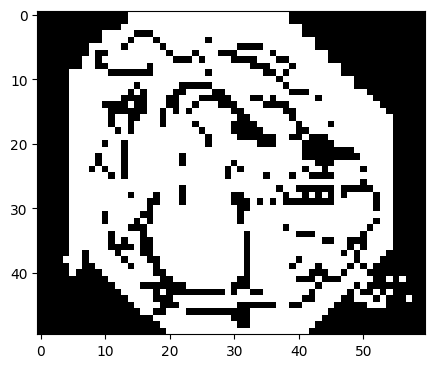

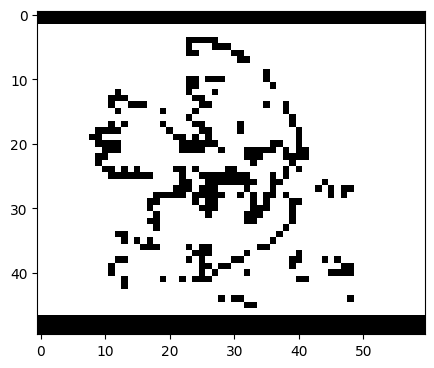

In [5]:
for image in image_list:
    create_composite_image(hopfield_network.run(image))

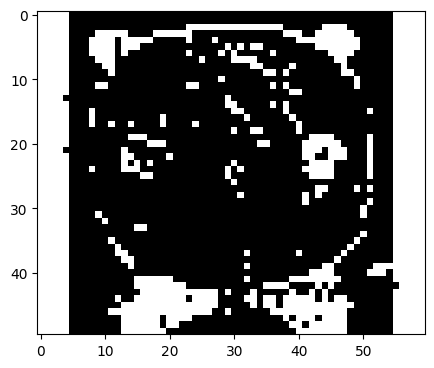

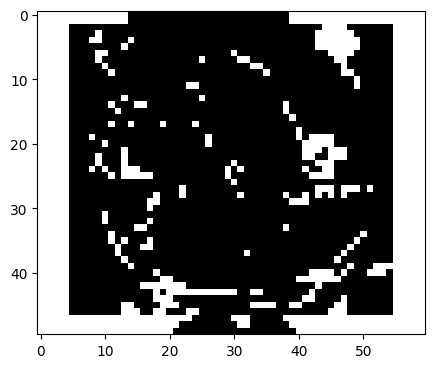

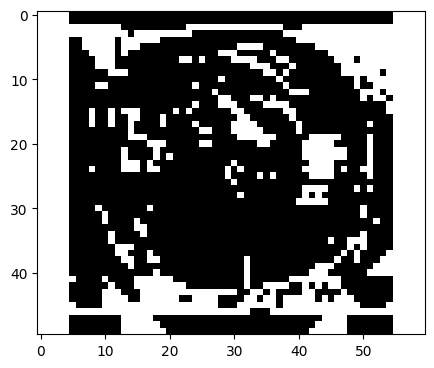

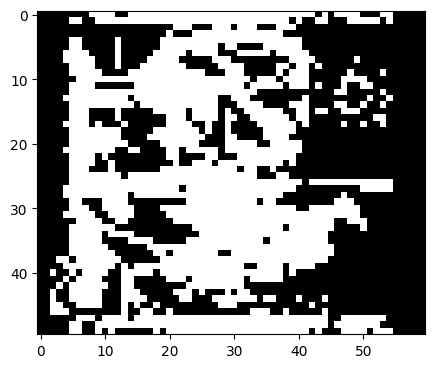

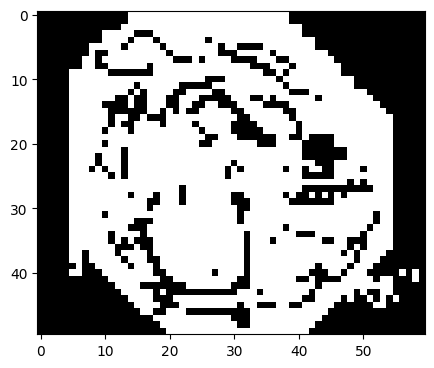

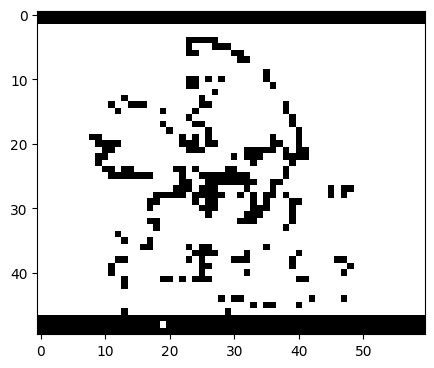

In [6]:
for pattern in noisy_pattern:
    create_composite_image(hopfield_network.run(pattern))

Pruebo que los patrones invertidos convergen a los patrones invertidos dado que la red de Hopfield es simétrica y los patrones invertidos son mínimos locales.

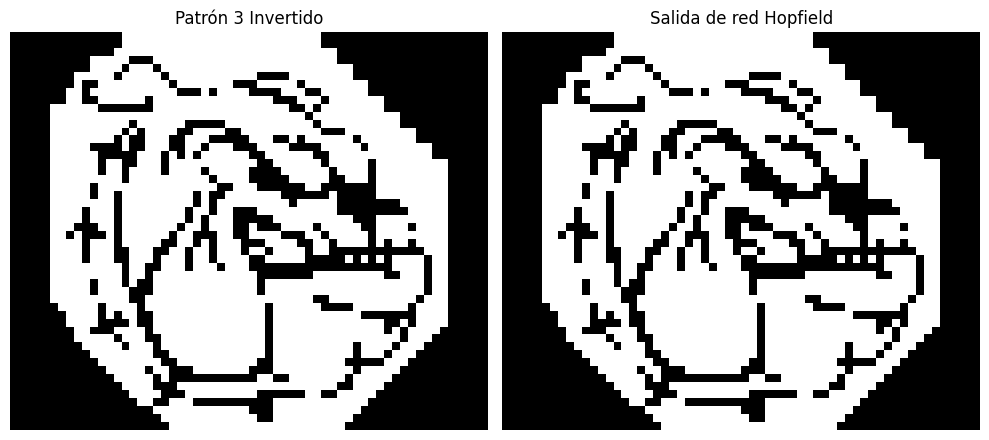

In [106]:
image_list = np.array(image_list)
image1 = image_list[0:3].sum(axis=0)
image2 = image_list[2].copy()
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(image2.reshape(50, 60), cmap='gray')
axes[0].set_title('Patrón 3 Invertido')
axes[0].axis('off')

axes[1].imshow(hopfield_network.run(image2).reshape(50, 60), cmap='gray')
axes[1].set_title('Salida de red Hopfield')
axes[1].axis('off')

plt.tight_layout()
plt.show()

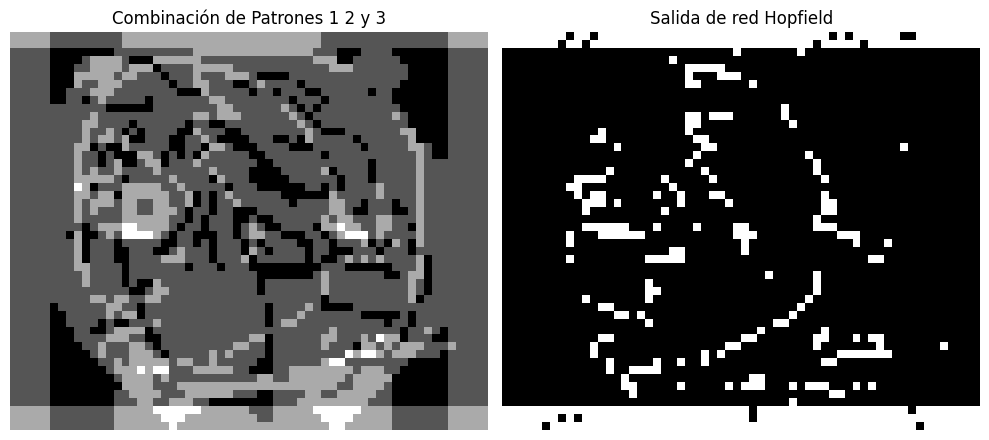

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
image_list[2]*=-1
axes[0].imshow(image1.reshape(50, 60), cmap='gray')
axes[0].set_title('Combinación de Patrones 1 2 y 3')
axes[0].axis('off')

axes[1].imshow(hopfield_network.run(image1).reshape(50, 60), cmap='gray')
axes[1].set_title('Salida de red Hopfield')
axes[1].axis('off')

plt.tight_layout()
plt.show()


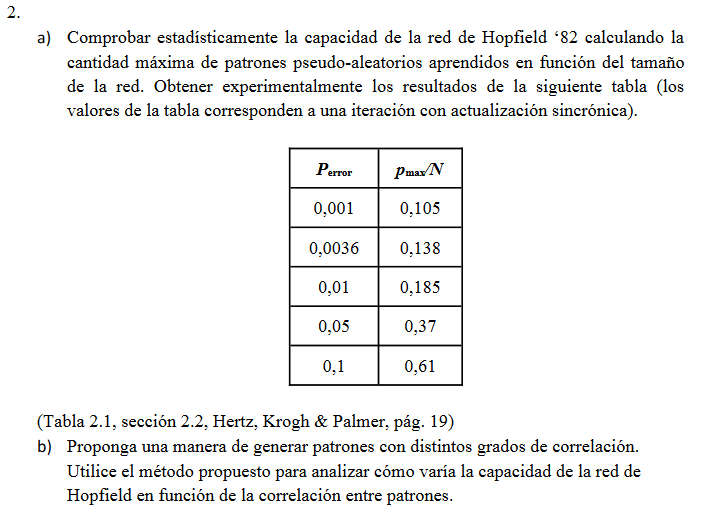

## Tips:
$Capacidad := P_{max}/N$

N cantidad de neuronas, M cantidad de patrones, $P_{max}$ es la cantidad máxima de patrones para su respectivo $P_{error}$ 

$E = \frac{\# Errores Totales}{N\cdot M}$

E va entre 0 y 1, se pide que $E < P_{error}$

### Estructura: 
1. Construyo $\hat{P}, \hat{P}_i = +-1, P(\hat{P}_i = 1) = 1/2$
2. Enseño $\hat{P}$
3. Actualización sincrónica 
4. Computo E
5. Pmax $\impliedby$ Pmax +1
 

In [7]:
from tabulate import tabulate
# Número de neuronas en la red
N = 300
MAXP = 300
random_patterns = np.random.choice([-1, 1], size=(MAXP, N))
max_errors = [0.001, 0.0036, 0.01, 0.05, 0.1]
pmax_n_teoricos = [0.105, 0.138, 0.185, 0.37, 0.61]
random_patterns[0].shape
h = HopfieldNetwork(N)
max_patrones = []
for error in max_errors:
    E = 0
    for i in range(1, MAXP):
        h.weights = np.zeros((N, N))
        h.train(random_patterns[:i])
        ET = 0
        for j in range(i):
            h.run_syncronically(random_patterns[j])
            ET += np.sum(random_patterns[j] != h.run_syncronically(random_patterns[j]))
        E = ET / (N * i)
        if E >= error:
            max_patrones.append(i)
            break  


data = {'Error': max_errors, 
        '# Patrones': max_patrones,
        'N (# Neuronas)': [N] * len(max_patrones),
        '# Patrones/N': [round(p/N, 4) for p in max_patrones], 
        '# Patrones/N (teórico)': pmax_n_teoricos, 
        'Diferencia': [round(abs(p/N - pt), 4) for p, pt in zip(max_patrones, pmax_n_teoricos)]}
print(tabulate(data, headers='keys', tablefmt='pretty'))

+--------+------------+----------------+--------------+------------------------+------------+
| Error  | # Patrones | N (# Neuronas) | # Patrones/N | # Patrones/N (teórico) | Diferencia |
+--------+------------+----------------+--------------+------------------------+------------+
| 0.001  |     34     |      300       |    0.1133    |         0.105          |   0.0083   |
| 0.0036 |     43     |      300       |    0.1433    |         0.138          |   0.0053   |
|  0.01  |     57     |      300       |     0.19     |         0.185          |   0.005    |
|  0.05  |    113     |      300       |    0.3767    |          0.37          |   0.0067   |
|  0.1   |    186     |      300       |     0.62     |          0.61          |    0.01    |
+--------+------------+----------------+--------------+------------------------+------------+


In [8]:

N = [100, 200, 300, 400, 500]
MAXP = 500
max_errors = [0.001, 0.0036, 0.01, 0.05, 0.1]
pmax_n_teoricos = [0.105, 0.138, 0.185, 0.37, 0.61]
max_patrones_all = []
for n in N:
    h = HopfieldNetwork(n)
    random_patterns = np.random.choice([-1, 1], size=(MAXP, n))
    max_patrones = []
    for error in max_errors:
        E = 0
        for i in range(1, MAXP):
            h.weights = np.zeros((n, n))
            h.train(random_patterns[:i])
            ET = 0
            for j in range(i):
                h.run_syncronically(random_patterns[j])
                ET += np.sum(random_patterns[j] != h.run_syncronically(random_patterns[j]))
            E = ET / (n * i)
            if E >= error:
                max_patrones.append(i)
                break
        max_patrones_all.append(max_patrones)          
max_patrones_all = np.array(max_patrones_all).reshape(len(N), len(max_errors))


KeyboardInterrupt: 

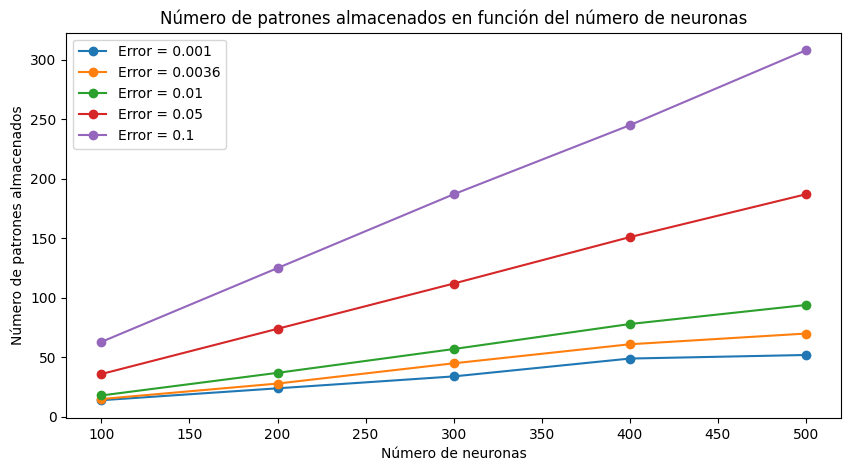

In [142]:
plt.figure(figsize=(10, 5))
for i in range(len(max_errors)):
    plt.plot(N, max_patrones_all[:,i], marker='o', label=f'Error = {max_errors[i]}')
plt.xlabel('Número de neuronas')
plt.ylabel('Número de patrones almacenados')
plt.title('Número de patrones almacenados en función del número de neuronas')
plt.legend()
plt.show()

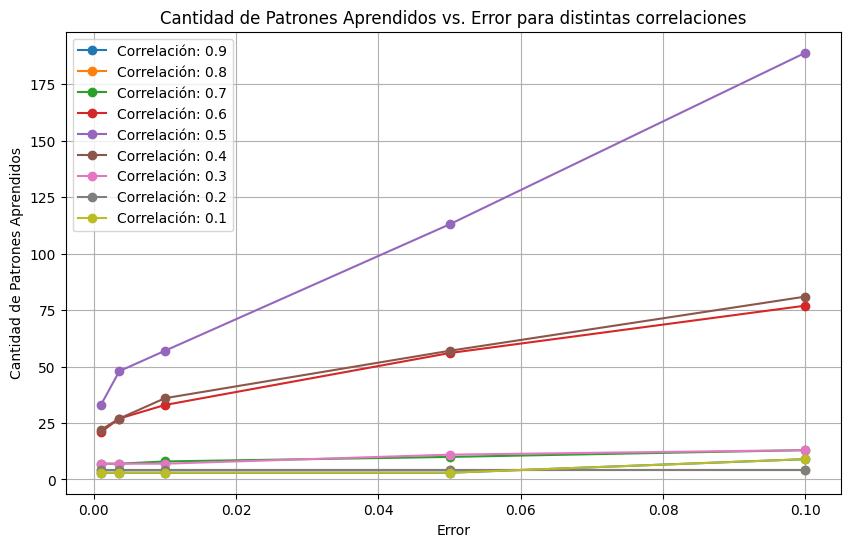

In [28]:

base_pattern = np.random.choice([-1, 1], size=(N))

corr_strengths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
max_patrones_corr_all = []

for corr_strength in corr_strengths:
    random_patterns_corr = np.zeros((MAXP, N))
    for i in range(MAXP):
        random_patterns_corr[i] = base_pattern.copy()
        num_changes = int(corr_strength * N)
        indexes = np.random.choice(N, num_changes, replace=False)
        random_patterns_corr[i][indexes] *= -1

    h2 = HopfieldNetwork(N)
    max_patrones_corr = []
    for error in max_errors:
        E = 0
        for i in range(1, MAXP):
            h2.weights = np.zeros((N, N))
            h2.train(random_patterns_corr[:i])
            ET = 0
            for j in range(i):
                h2.run_syncronically(random_patterns_corr[j])
                ET += np.sum(random_patterns_corr[j] != h2.run_syncronically(random_patterns_corr[j]))
            E = ET / (N * i)
            if E >= error:
                max_patrones_corr.append(i)
                break
    max_patrones_corr_all.append(max_patrones_corr)


plt.figure(figsize=(10, 6))
for i, corr_strength in enumerate(corr_strengths):
    plt.plot(max_errors, max_patrones_corr_all[i],'o-', label=f'Correlación: {round(1-corr_strength, 2)}')

plt.xlabel('Error')
plt.ylabel('Cantidad de Patrones Aprendidos')
plt.title('Cantidad de Patrones Aprendidos vs. Error para distintas correlaciones')
plt.legend()
plt.grid(True)
plt.show()
